In [ ]:
lapply(c("dplyr", "Seurat", "ggplot2", "SingleR", "SingleCellExperiment", "zellkonverter", "sceasy", "anndata", "ProjecTILs", "scCustomize"), library, character.only = T)
pkg_dir <- "./pkg/ProjecTILs/R"
source(file.path(pkg_dir, "main.R"))
source(file.path(pkg_dir, "utils.R"))
source(file.path(pkg_dir, "rotations.R"))
source(file.path(pkg_dir, "seurat_utils.R"))
options(repr.plot.width=15, repr.plot.height=15)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.5.0 but the current version is
4.5.1; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,

[[1]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
 [1] "Seurat"       "SeuratObject" "sp"           "dplyr"        "stats"       
 [6] "graphics"     "grDevices"    "utils"        "datasets"     "methods"     
[11] "base"        

[[3]]
 [1] "ggplot2"      "Seurat"       "SeuratObject" "sp"           "dplyr"       
 [6] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[11] "methods"      "base"        

[[4]]
 [1] "SingleR"              "SummarizedExperiment" "Biobase"             
 [4] "GenomicRanges"        "GenomeInfoDb"         "IRanges"             
 [7] "S4Vectors"            "BiocGenerics"         "generics"            
[10] "stats4"               "MatrixGenerics"       "matrixStats"         
[13] "ggplot2"              "Seurat"               "SeuratObject"        
[16] "sp"                   "dplyr"                "stats"               
[19] "graphics"             "grDevices"            "utils"               
[22] "datasets"             "methods"              "base"                

[[5]]
 [1] "SingleCellExperiment" "SingleR"              "SummarizedExperiment"
 [4] "Biobase"              "GenomicRanges"        "GenomeInfoDb"        
 [7] "IRanges"              "S4Vectors"            "BiocGenerics"        
[10] "generics"             "stats4"               "MatrixGenerics"      
[13] "matrixStats"          "ggplot2"              "Seurat"              
[16] "SeuratObject"         "sp"                   "dplyr"               
[19] "stats"                "graphics"             "grDevices"           
[22] "utils"                "datasets"             "methods"             
[25] "base"                

[[6]]
 [1] "zellkonverter"        "SingleCellExperiment" "SingleR"             
 [4] "SummarizedExperiment" "Biobase"              "GenomicRanges"       
 [7] "GenomeInfoDb"         "IRanges"              "S4Vectors"           
[10] "BiocGenerics"         "generics"             "stats4"              
[13] "MatrixGenerics"       "matrixStats"          "ggplot2"             
[16] "Seurat"               "SeuratObject"         "sp"                  
[19] "dplyr"                "stats"                "graphics"            
[22] "grDevices"            "utils"                "datasets"            
[25] "methods"              "base"                

[[7]]
 [1] "sceasy"               "reticulate"           "zellkonverter"       
 [4] "SingleCellExperiment" "SingleR"              "SummarizedExperiment"
 [7] "Biobase"              "GenomicRanges"        "GenomeInfoDb"        
[10] "IRanges"              "S4Vectors"            "BiocGenerics"        
[13] "generics"             "stats4"               "MatrixGenerics"      
[16] "matrixStats"          "ggplot2"              "Seurat"              
[19] "SeuratObject"         "sp"                   "dplyr"               
[22] "stats"                "graphics"             "grDevices"           
[25] "utils"                "datasets"             "methods"             
[28] "base"                

[[8]]
 [1] "anndata"              "sceasy"               "reticulate"          
 [4] "zellkonverter"        "SingleCellExperiment" "SingleR"             
 [7] "SummarizedExperiment" "Biobase"              "GenomicRanges"       
[10] "GenomeInfoDb"         "IRanges"              "S4Vectors"           
[13] "BiocGenerics"         "generics"             "stats4"              
[16] "MatrixGenerics"       "matrixStats"          "ggplot2"             
[19] "Seurat"               "SeuratObject"         "sp"                  
[22] "dplyr"                "stats"                "graphics"            
[25] "grDevices"            "utils"                "datasets"            
[28] "methods"              "base"                

[[9]]
 [1] "ProjecTILs"           "anndata"              "sceasy"              
 [4] "reticulate"           "zellkonverter"        "SingleCellExperiment"
 [7] "SingleR"              "SummarizedExperi

In [2]:
is_outlier <- function(seurat.obj, metric, nmads=5) {
  vec <- seurat.obj[[metric, drop=TRUE]]
  med <- median(vec)
  mad <- mad(vec)
  outlier <- (vec < (med - nmads * mad)) | (vec > (med + nmads * mad))
  return(outlier)
}

st_pre_qc <- function(seurat.obj) {
  seurat.obj[["percent.mt"]] <- PercentageFeatureSet(seurat.obj, pattern = "^MT-")
  seurat.obj[["log1p_nCount_Xenium"]] <- log1p(seurat.obj$nCount_Xenium)
  seurat.obj[["log1p_nFeature_Xenium"]] <- log1p(seurat.obj$nFeature_Xenium)
  seurat.obj[["outlier"]] <- is_outlier(seurat.obj, "log1p_nCount_Xenium", nmads=5) | is_outlier(seurat.obj, "log1p_nFeature_Xenium", nmads=5)
  print(table(seurat.obj$outlier))
  seurat.obj <- subset(seurat.obj, subset = outlier == FALSE & percent.mt < 10)
  return(seurat.obj)
}

In [ ]:
ref_raw <- readRDS("./dat/sc_rna_ref/RNA_rawcounts_matrix.rds")
metadata <- read.csv("./dat/sc_rna_ref/metadata.csv", row.names = 1)
sce <- SingleCellExperiment(
    assays = list(counts = ref_raw),
    colData = metadata
    )
flex_data.obj <- as.Seurat(sce, counts = "counts", data = NULL)

# Add metadata column for percent.mt
flex_data.obj[["percent.mt"]] <- PercentageFeatureSet(flex_data.obj, pattern = "^MT-")
# Subset data based on desired filters
flex_data.obj <- subset(flex_data.obj, subset = Subtype == "adenocarcinoma")
flex_data.obj <- subset(flex_data.obj, subset = nCount_RNA > 200 & nCount_RNA < 10000 & percent.mt < 10)

flex_data.obj$Visium_celltype_label <- flex_data.obj$Cell_Cluster_level2

flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "CDKN2A Cancer"] <- "Malignant"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "SOX2 Cancer"] <- "Malignant"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "CXCL1 Cancer"] <- "Malignant"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "LAMC2 Cancer"] <- "Malignant"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "Proliferating Cancer"] <- "Malignant"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "cDC2/moDCs"] <- "cDC"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "Monocytes"] <- "Macrophage"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "Low quality Mac"] <- "Macrophage"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "Lipid-associated Mac"] <- "Macrophage"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "Alveolar Mac"] <- "Macrophage"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "Proliferating Mac"] <- "Macrophage"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "Pathological Alveolar"] <- "Unidentifiable"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "Alveolar"] <- "Unidentifiable"
flex_data.obj$Visium_celltype_label[flex_data.obj$Cell_Cluster_level2 == "Ciliated"] <- "Unidentifiable"


Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“Removing 42348 cells missing data for vars requested”


In [4]:
table(flex_data.obj$Visium_celltype_label)


               CAF          CD4+ Treg           CD8+ Tem                cDC 
              2053               5436              13265               2380 
       Endothelial         Macrophage          Malignant               Mast 
              1697              19926               3401               3257 
    Mature naive B            Naive T        Neutrophils                 NK 
             14749              26045               4263               3042 
              pDCs             Plasma Proliferating T/NK                SMC 
               562               4282                798               1137 
    Unidentifiable 
              6847 

In [4]:
tcells.obj <- subset(flex_data.obj, subset = Visium_celltype_label %in% c("CD4+ Treg", "CD8+ Tem", "NK", "Naive T", "Proliferating T/NK"))

## Xenium preprocessing

In [ ]:
xenium_path <- "./dat/Xenium_5k_humanLung_Cancer_FFPE/"
xenium.obj <- LoadXenium(xenium_path, fov = "fov", molecule.coordinates = FALSE)
DefaultAssay(xenium.obj) <- "Xenium"

# Add log1p_nCount_RNA, log1p_nFeatures
xenium.obj@meta.data$nCount_Xenium_log <- log1p(xenium.obj@meta.data$nCount_Xenium)
xenium.obj@meta.data$nFeature_Xenium_log <- log1p(xenium.obj@meta.data$nFeature_Xenium)

# Remove any empty cells
xenium.obj <- subset(xenium.obj, subset = nCount_Xenium > 40 & nFeature_Xenium > 15)


Genome matrix has multiple modalities, returning a list of matrices for this genome

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validat

In [24]:
xenium.obj <- st_pre_qc(xenium.obj)


 FALSE 
262239 


In [ ]:
# Add singleR cell type annotation
singleR.celltype <- read.csv("./out/singler_out/lung_xenium_singler_pred_label_only_visium_labels.csv.gz", row.names = 1)

In [29]:
singler.celltype <- singleR.celltype$pred.labels; names(singler.celltype) <- rownames(singleR.celltype)
xenium.obj <- AddMetaData(xenium.obj, metadata = singler.celltype, col.name = "SingleR_celltype")

In [30]:
table(xenium.obj$SingleR_celltype)


        B.cell            CAF            cDC    Endothelial     Macrophage 
          8599          38505           4292          44779          22690 
     Malignant           Mast        Naive T    Neutrophils             NK 
         15786           3895          17096           1412           1336 
          pDCs         Plasma            SMC          T.CD4          T.CD8 
          1112          10057          19497           8642           8976 
Unidentifiable 
         55565 

In [33]:
data.Tcells <- subset(xenium.obj, subset = SingleR_celltype %in% c("T.CD4", "T.CD8", "NK", "Naive T"))

Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Seurat objects”


## Reference map

In [13]:
list.reference.maps()

collection.CSI,reference.atlas,name,figshare_id
<chr>,<chr>,<chr>,<int>
human,CD4,sketched_CD4T_human_ref_v2.rds,26310994
human,CD8,sketched_CD8T_human_ref_v1.rds,26310994
human,DC,sketched_DC_human_ref_v2.rds,26310994
human,MoMac,sketched_MoMac_human_v1.rds,26310994
mouse,Virus_CD4T,ref_LCMV_CD4_mouse_release_v1.rds,16592693
mouse,Virus_CD8T,ref_CD8_LCMV_mouse_v2.rds,23764572
mouse,TILs,ref_TILAtlas_mouse_v1.rds,12478571


In [6]:
t.ref <- get.reference.maps(reference = c("CD4", "CD8"))

Retrieving all ProjecTILs reference atlases


Retrieving CD4, CD8 ProjecTILs reference atlases




[1] "Loaded Custom Reference map custom_reference"
-------
[1] "Loaded Custom Reference map Human CD8 TILs"
-------


In [7]:
t.int.ref <- merge(x=t.ref$human$CD4, y = t.ref$human$CD8, add.cell.ids = c("CD4", "CD8"), project = "Tcells_ref")

In [8]:
t.int.ref <- Convert_Assay(t.int.ref, assay = "RNA", "V5")

Converting assay "RNA" from Assay to Assay5.


In [9]:
colnames(t.int.ref@meta.data)

[1] "orig.ident"              "nCount_RNA"             
  [3] "nFeature_RNA"            "patient"                
  [5] "cancerType"              "loc"                    
  [7] "TCR"                     "dataset"                
  [9] "batchV_dataset"          "cellCycle.G1S"          
 [11] "cellCycle.G2M"           "scGate_multi"           
 [13] "functional.cluster"      "sub.cluster"            
 [15] "leverage.score"          "mito.genes"             
 [17] "db.class"                "db.score"               
 [19] "PT.annot"                "PT.score"               
 [21] "HPCA.labels"             "HPCA.pruned.labels"     
 [23] "Monaco.labels"           "Monaco.pruned.labels"   
 [25] "barcode"                 "CTgene"                 
 [27] "CTnt"                    "CTaa"                   
 [29] "CTstrict"                "Frequency"              
 [31] "cloneType"               "SampleLabel"            
 [33] "SampleID"                "GEO_RNA"                
 [35] "Cohort"                  "Type"                   
 [37] "Tissue"                  "Sample"                 
 [39] "Sorted"                  "Age"                    
 [41] "Gender"                  "Ethnicity"              
 [43] "T"                       "M"                      
 [45] "N"                       "Stage"                  
 [47] "Histology"               "Subtype"                
 [49] "Treatments"              "Response"               
 [51] "Immune_UCell"            "Lymphoid_UCell"         
 [53] "Tcell_UCell"             "Epithelial_UCell"       
 [55] "Stromal2_UCell"          "Erythrocyte_UCell"      
 [57] "Myeloid_UCell"           "MoMacDC_UCell"          
 [59] "TAM_UCell"               "Neutrophils_UCell"      
 [61] "Talphabeta_UCell"        "Bcell_UCell"            
 [63] "NK_UCell"                "Plasma_cell_UCell"      
 [65] "CD8T_UCell"              "Tgammadelta_UCell"      
 [67] "CD4T_UCell"              "Treg_UCell"             
 [69] "CD8_INN_UCell"           "CD8_INN2_UCell"         
 [71] "is.pure"                 "IFN"                    
 [73] "CD8_EM_UCell"            "CD8_TEMRA_UCell"        
 [75] "Exhausted_UCell"         "CD8_TEX_UCell"          
 [77] "CD8_TRM_UCell"           "CD8_GD_UCell"           
 [79] "CD8_MAIT_UCell"          "CD8_N_UCell"            
 [81] "CD8_TPEX_UCell"          "Cytotoxic_UCell"        
 [83] "Stemness_UCell"          "is.pure_CD8_EM"         
 [85] "is.pure_CD8_MAIT"        "is.pure_CD8_N"          
 [87] "is.pure_CD8_TEMRA"       "is.pure_CD8_TEX"        
 [89] "is.pure_CD8_TPEX"        "db.weight.score"        
 [91] "db.ratio"                "HPCA.first.labels"      
 [93] "functional.cluster.conf" "sample"                 
 [95] "ID"                      "integrated_snn_res.0.7" 
 [97] "seurat_clusters"         "integrated_snn_res.0.5" 
 [99] "nCount_RNA_trimmed"      "nFeature_RNA_trimmed"

In [10]:
# Use seurat label transfer approach 
# pre-process dataset (without integration)
t.int.ref <- SCTransform(t.int.ref, assay = "RNA", verbose = FALSE)
t.int.ref <- FindVariableFeatures(t.int.ref, assay = "RNA")
t.int.ref <- ScaleData(t.int.ref, assay = "RNA")
t.int.ref <- RunPCA(t.int.ref, assay = "RNA")
t.int.ref <- FindNeighbors(t.int.ref, dims = 1:30, assay = "RNA")
t.int.ref <- FindClusters(t.int.ref, graph.name = "RNA_snn")


Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  CCL5, NKG7, CD8A, CD8B, CTSW, GZMK, GZMA, ANXA1, CCL4, GZMH 
	   CST7, FOS, MATK, KLRD1, KLF2, TC2N, LITAF, SAMD3, AOAH, KLRG1 
	   CLEC2B, SNHG29, CD69, ZFP36L2, RNF125, FOSB, IER2, PRF1, PLAC8, PLAAT4 
Negative:  TNFRSF18, TNFRSF4, BATF, GK, FOXP3, CTLA4, PKM, IL2RA, TYMP, DUSP4 
	   TBC1D4, SPOCK2, TIGIT, CARD16, DNPH1, GPX1, HSPB1, SOD1, STAM, CCR8 
	   PRDX1, SNX9, FKBP1A, GAPDH, CD82, EBI3, NMB, CACYBP, ICOS, CCDC50 
PC_ 2 
Positive:  DUSP1, RPS10, NR4A2, DNAJB1, FOSB, JUNB, RGCC, DNAJA1, HSPH1, EEF1G 
	   NR4A1, HSP90AA1, CXCR4, TSC22D3, ZFP36L2, FOS, HSPA1B, ZFP36, KLF2, ZNF331 
	   CDKN1A, TAGAP, CRIP1, UB

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3000
Number of edges: 99655

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8843
Number of communities: 18
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:18:27 UMAP embedding parameters a = 0.9922 b = 1.112

14:18:27 Read 3000 rows and found 30 numeric columns

14:18:27 Using Annoy for neighbor search, n_neighbors = 30

14:18:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:18:27 Writing NN index file to temp file /tmp/RtmpgGsmck/file21e316118cb3a2

14:18:27 Searching Annoy index using 1 thread, search_k = 3000

14:18:28 Annoy recall = 100%

14:18:28 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

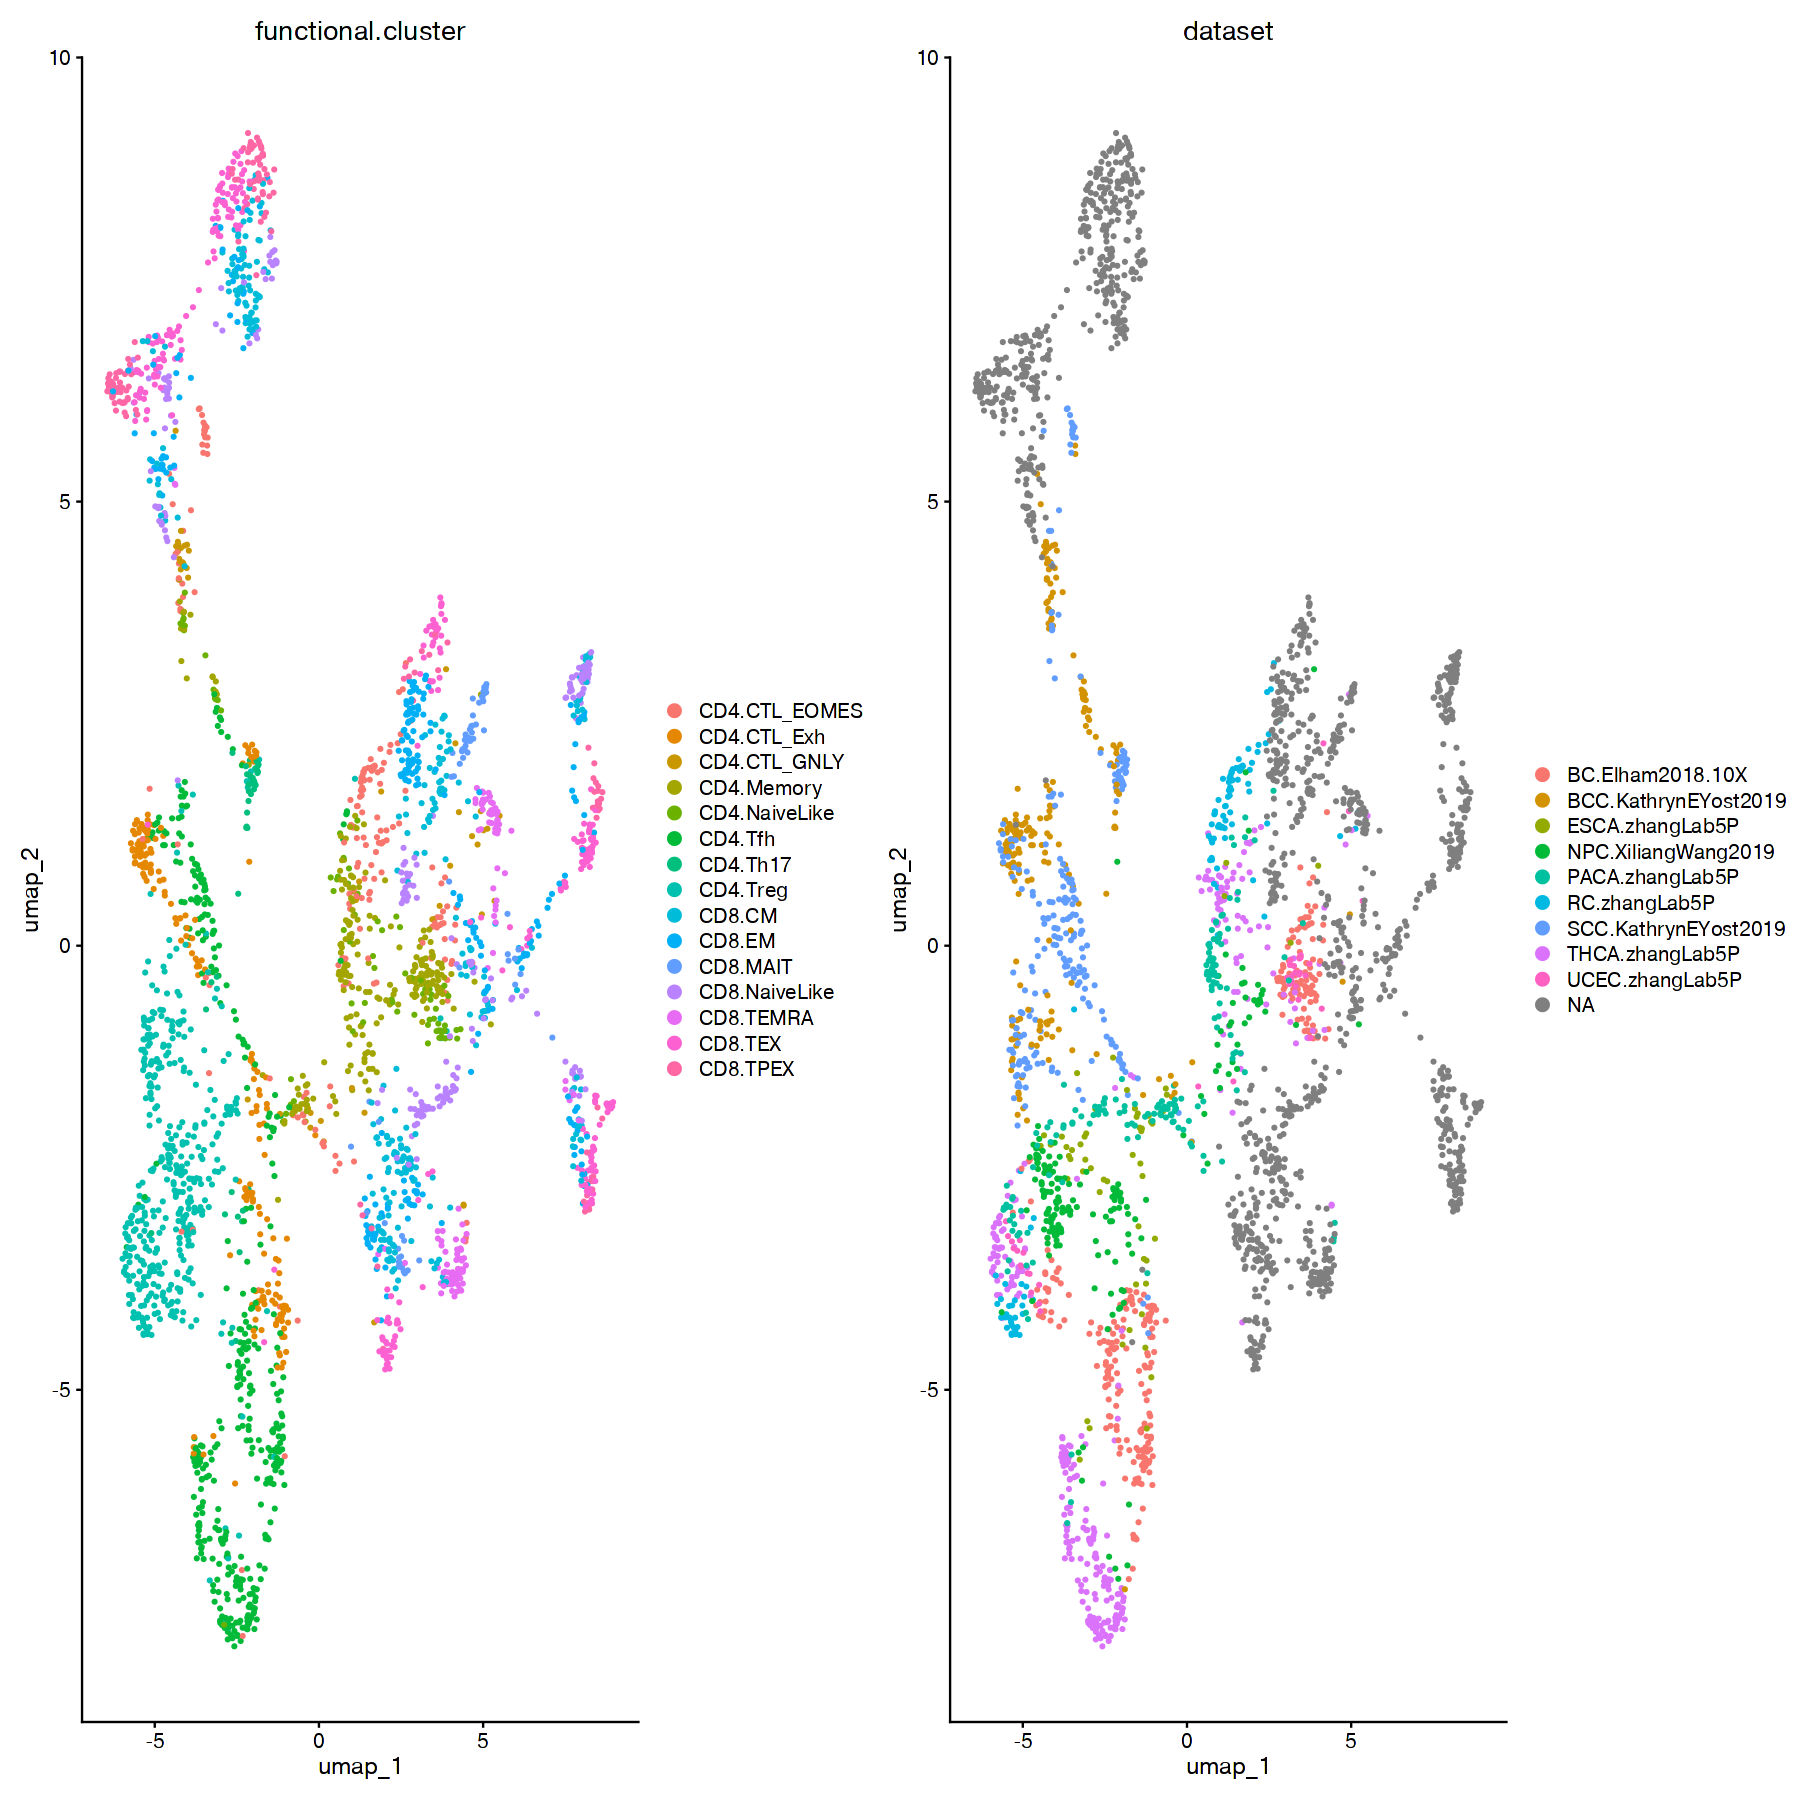

In [11]:
t.int.ref <- RunUMAP(t.int.ref, dims = 1:30)
DimPlot(t.int.ref, group.by = c("functional.cluster", "dataset"))

In [12]:
tcells.obj <- SCTransform(tcells.obj, assay = "originalexp", verbose = FALSE)

In [13]:
tcells.anchors <- FindTransferAnchors(reference = t.int.ref, query = tcells.obj, dims = 1:30, reference.reduction = "pca")
predictions <- TransferData(anchorset = tcells.anchors, refdata = t.int.ref$functional.cluster, dims = 1:30)
tcells.obj <- AddMetaData(tcells.obj, metadata = predictions)

Warning message in ValidateParams_FindTransferAnchors(reference = reference, query = query, :
“Both reference and query assays have been processed with SCTransform.Setting normalization.method = 'SCT' and continuing.”
Normalizing query using reference SCT model

Only one SCT model detected; no need to select.

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 7771 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [14]:
colnames(tcells.obj@meta.data)

[1] "orig.ident"                     "nCount_originalexp"            
 [3] "nFeature_originalexp"           "nCount_RNA"                    
 [5] "nFeature_RNA"                   "Percent_mt"                    
 [7] "Patient"                        "Gender"                        
 [9] "Subtype"                        "Stage"                         
[11] "seurat_clusters"                "Study"                         
[13] "Cell_Cluster_level1"            "Cell_Cluster_level2"           
[15] "validation_original_annotation" "id"                            
[17] "predicted.celltypel1.score"     "predicted.celltypel1"          
[19] "predicted.celltypel2.score"     "predicted.celltypel2"          
[21] "percent.mt"                     "Visium_celltype_label"         
[23] "nCount_SCT"                     "nFeature_SCT"                  
[25] "predicted.id"                   "prediction.score.CD4.Tfh"      
[27] "prediction.score.CD4.Memory"    "prediction.score.CD4.Treg"     
[29] "prediction.score.CD4.NaiveLike" "prediction.score.CD4.CTL_EOMES"
[31] "prediction.score.CD4.CTL_Exh"   "prediction.score.CD4.Th17"     
[33] "prediction.score.CD4.CTL_GNLY"  "prediction.score.CD8.CM"       
[35] "prediction.score.CD8.TEX"       "prediction.score.CD8.TPEX"     
[37] "prediction.score.CD8.EM"        "prediction.score.CD8.NaiveLike"
[39] "prediction.score.CD8.MAIT"      "prediction.score.CD8.TEMRA"    
[41] "prediction.score.max"

In [15]:
table(tcells.obj$Cell_Cluster_level2)


         CD4+ Treg           CD8+ Tem            Naive T                 NK 
              5436              13265              26045               3042 
Proliferating T/NK 
               798 

In [ ]:
write.csv(predictions, file = "./dat/sc_rna_ref/tcell_states.csv", row.names = TRUE)

In [ ]:
predictions <- read.csv("./dat/sc_rna_ref/tcell_states.csv", row.names = 1)

In [6]:
# find the max predictions for each cells in predictions
head(predictions)
pred_max_cellstate <- apply(predictions[,2:dim(predictions)[2]], 1, function(x) names(x)[which.max(x)])

,predicted.id,prediction.score.CD4.Tfh,prediction.score.CD4.Memory,prediction.score.CD4.Treg,prediction.score.CD4.NaiveLike,prediction.score.CD4.CTL_EOMES,prediction.score.CD4.CTL_Exh,prediction.score.CD4.Th17,prediction.score.CD4.CTL_GNLY,prediction.score.CD8.CM,prediction.score.CD8.TEX,prediction.score.CD8.TPEX,prediction.score.CD8.EM,prediction.score.CD8.NaiveLike,prediction.score.CD8.MAIT,prediction.score.CD8.TEMRA,prediction.score.max
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P2_X3_TCCCCATTCAGT,CD8.NaiveLike,0,0.01482082,0,0.01348541,0,0,0,0,0.04682991,0.000000000,0.006582347,0.31635705,0.6019245,0.000000000,0,0.6019245
P5_X8_GCCGTGAGCCTG,CD8.NaiveLike,0,0.04151960,0,0.01968189,0,0,0,0,0.03250757,0.045621014,0.000000000,0.03395349,0.7549277,0.071788769,0,0.7549277
P5_X9_TCCCATTCGTCT,CD8.NaiveLike,0,0.01913402,0,0.01735606,0,0,0,0,0.06055310,0.000000000,0.006330067,0.29057576,0.6060510,0.000000000,0,0.6060510
P5_X9_CCATTCACCGCT,CD8.NaiveLike,0,0.01932730,0,0.02128432,0,0,0,0,0.06716345,0.000000000,0.007850687,0.28442175,0.5999525,0.000000000,0,0.5999525
P5_X9_TCCCGTCACTCT,CD8.NaiveLike,0,0.01451302,0,0.01337552,0,0,0,0,0.06109370,0.000000000,0.007259072,0.31777581,0.5837250,0.002257865,0,0.5837250
P5_X9_GCCCCATTCACG,CD8.NaiveLike,0,0.01147461,0,0.00000000,0,0,0,0,0.04824788,0.005785417,0.018024538,0.34376572,0.5637928,0.008909060,0,0.5637928


In [7]:
tcells.obj <- AddMetaData(tcells.obj, metadata = pred_max_cellstate, col.name = "t_cell_state")

In [8]:
head(tcells.obj@meta.data)

,orig.ident,nCount_originalexp,nFeature_originalexp,nCount_RNA,nFeature_RNA,Percent_mt,Patient,Gender,Subtype,Stage,⋯,Cell_Cluster_level2,validation_original_annotation,id,predicted.celltypel1.score,predicted.celltypel1,predicted.celltypel2.score,predicted.celltypel2,percent.mt,Visium_celltype_label,t_cell_state
,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
P2_X3_TCCCCATTCAGT,X3,5249,376,5249,376,2.667175,S5P2,M,adenocarcinoma,III/IV,⋯,Naive T,NA,Reference,NA,NA,NA,NA,2.667175,Naive T,prediction.score.CD8.NaiveLike
P5_X8_GCCGTGAGCCTG,X8,1174,575,1174,575,7.836457,S5P5,M,adenocarcinoma,III/IV,⋯,Naive T,NA,Reference,NA,NA,NA,NA,7.836457,Naive T,prediction.score.CD8.NaiveLike
P5_X9_TCCCATTCGTCT,X9,7074,290,7074,290,3.392706,S5P5,M,adenocarcinoma,III/IV,⋯,Naive T,NA,Reference,NA,NA,NA,NA,3.392706,Naive T,prediction.score.CD8.NaiveLike
P5_X9_CCATTCACCGCT,X9,5584,277,5584,277,3.474212,S5P5,M,adenocarcinoma,III/IV,⋯,Naive T,NA,Reference,NA,NA,NA,NA,3.474212,Naive T,prediction.score.CD8.NaiveLike
P5_X9_TCCCGTCACTCT,X9,3921,208,3921,208,4.539658,S5P5,M,adenocarcinoma,III/IV,⋯,Naive T,NA,Reference,NA,NA,NA,NA,4.539658,Naive T,prediction.score.CD8.NaiveLike
P5_X9_GCCCCATTCACG,X9,3313,403,3313,403,9.115605,S5P5,M,adenocarcinoma,III/IV,⋯,Naive T,NA,Reference,NA,NA,NA,NA,9.115605,Naive T,prediction.score.CD8.NaiveLike


In [ ]:
tcells.obj


prediction.score.CD4.CTL_EOMES   prediction.score.CD4.CTL_Exh 
                          2344                            856 
 prediction.score.CD4.CTL_GNLY    prediction.score.CD4.Memory 
                           363                           6462 
prediction.score.CD4.NaiveLike       prediction.score.CD4.Tfh 
                          3909                           2261 
     prediction.score.CD4.Th17      prediction.score.CD4.Treg 
                            63                           3647 
       prediction.score.CD8.CM        prediction.score.CD8.EM 
                          5190                           3864 
     prediction.score.CD8.MAIT prediction.score.CD8.NaiveLike 
                           466                          14562 
    prediction.score.CD8.TEMRA       prediction.score.CD8.TEX 
                          2200                           2205 
     prediction.score.CD8.TPEX 
                           194 

In [11]:
tcells.obj@meta.data$t_state_simple <- "Other"
tcells.obj@meta.data$t_state_simple[grepl("CD4", tcells.obj@meta.data$t_cell_state)] <- "CD4_Tcell"
tcells.obj@meta.data$t_state_simple[grepl("CD8", tcells.obj@meta.data$t_cell_state)] <- "CD8_Tcell"
table(tcells.obj@meta.data$t_state_simple)


CD4_Tcell CD8_Tcell 
    19905     28681 

In [12]:
head(Cells(tcells.obj))

[1] "P2_X3_TCCCCATTCAGT" "P5_X8_GCCGTGAGCCTG" "P5_X9_TCCCATTCGTCT"
[4] "P5_X9_CCATTCACCGCT" "P5_X9_TCCCGTCACTCT" "P5_X9_GCCCCATTCACG"

In [13]:
# Add to the original flex_data.obj
t_cell_states <- tcells.obj@meta.data$t_state_simple; names(t_cell_states) <- Cells(tcells.obj)
flex_data.obj <- AddMetaData(flex_data.obj, metadata = t_cell_states, col.name = "t_cell_state")

In [16]:
head(flex_data.obj@meta.data)

,orig.ident,nCount_originalexp,nFeature_originalexp,nCount_RNA,nFeature_RNA,Percent_mt,Patient,Gender,Subtype,Stage,⋯,Cell_Cluster_level2,validation_original_annotation,id,predicted.celltypel1.score,predicted.celltypel1,predicted.celltypel2.score,predicted.celltypel2,percent.mt,Visium_celltype_label,t_cell_state
,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
P2_X3_TCCCCATTCAGT,X3,5249,376,5249,376,2.6671747,S5P2,M,adenocarcinoma,III/IV,⋯,Naive T,NA,Reference,NA,NA,NA,NA,2.6671747,CD8_Tcell,CD8_Tcell
P2_X3_ACGTGCCCGATC,X3,9278,2259,9278,2259,9.1183445,S5P2,M,adenocarcinoma,III/IV,⋯,CXCL1 Cancer,NA,Reference,NA,NA,NA,NA,9.1183445,Malignant,NA
P2_X3_CTCGAAGGGCAC,X3,9386,2954,9386,2954,5.2525037,S5P2,M,adenocarcinoma,III/IV,⋯,CXCL1 Cancer,NA,Reference,NA,NA,NA,NA,5.2525037,Malignant,NA
P2_X3_TAATGACCGCTT,X3,9233,2906,9233,2906,8.2205134,S5P2,M,adenocarcinoma,III/IV,⋯,Pathological Alveolar,NA,Reference,NA,NA,NA,NA,8.2205134,Unidentifiable,NA
P2_X3_CTACAAGTTCAT,X3,7628,1840,7628,1840,0.2753015,S5P2,M,adenocarcinoma,III/IV,⋯,CXCL1 Cancer,NA,Reference,NA,NA,NA,NA,0.2753015,Malignant,NA
P2_X3_GTTTTAGGGGGC,X3,6841,2332,6841,2332,8.7560298,S5P2,M,adenocarcinoma,III/IV,⋯,Pathological Alveolar,NA,Reference,NA,NA,NA,NA,8.7560298,Unidentifiable,NA


In [15]:
flex_data.obj@meta.data$Visium_celltype_label[!is.na(flex_data.obj@meta.data$t_cell_state)] <- flex_data.obj@meta.data$t_cell_state[!is.na(flex_data.obj@meta.data$t_cell_state)]

In [ ]:
saveRDS(flex_data.obj, file = "./dat/sc_rna_ref/lung_xenium_flexdata_with_tcell_states.rds")